# Backblaze Drive Stats AI Agent Demo

This notebook shows how to create an AI agent that answers questions about hard drive reliability based on over ten years of raw data from the Backblaze [Drive Stats](https://www.backblaze.com/drivestats) project.

Note that, due to the non-deterministic nature of large language models (LLMs), as well as changes in the LangChain framework, and other dependencies, over time, you will likely see different results if you run this notebook yourself.

## Acknowledgements

This work is based on the LangChain [Build a Question/Answering system over SQL data](https://python.langchain.com/docs/tutorials/sql_qa/) tutorial.

## Install Dependencies

First, install the required Python packages. You will need to restart the Jupyter kernel before you can use newly-installed packages. You can uncomment the second line, or manually restart the kernel.

In [1]:
%pip install --upgrade --quiet -r requirements.txt

# Uncomment this line to restart the kernel so that it uses the new modules
# get_ipython().kernel.do_shutdown(restart=True)

## Getting a Connection to the Database

The Drive Stats data set is publicly available in several formats, including Iceberg/Parquet. In this demo, we're using the [Trino](https://trino.io/) open source SQL query engine to query the data set.

LangChain's `SQLDatabase` class provides access to databases via the [SQLAlchemy](https://www.sqlalchemy.org/) open-source Python library. The necessary Python modules are installed via [`requirements.txt`](requirements.txt), so all we need to do is use a URL that follows the pattern `trino://<username>:<password>@<host>:<port>/<catalog>/<schema>`:

In [2]:
from langchain_community.utilities import SQLDatabase
import warnings

# Suppress warnings triggered by SQLAlchemy not finding Trino partition columns
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    db = SQLDatabase.from_uri('trino://admin@localhost:8080/iceberg/drivestats')

Run a simple query to check that we can access data.

In [3]:
db.run("SELECT COUNT(*) FROM drivestats")

'[(564566016,)]'

## Using OpenAI to Generate a SQL Query

In this demo, we're using LangChain's OpenAI chat model integration. You could use a different chat model, such as [Ollama](https://python.langchain.com/docs/integrations/chat/ollama/) or [Anthropic](https://python.langchain.com/docs/integrations/chat/anthropic/), if you wish. See the accompanying notebook, [agent_demo_deepseek.ipynb](agent_demo_deepseek.ipynb) for notes on running a DeepSeek model.

You must create a `.env` file containing your OpenAI API token. Never, ever, embed credentials in code!

```
OPENAI_API_KEY=<your-openai-api-key>
```

In [4]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini")

We'll use the default LangChain SQL query system prompt as a starting point.

In [5]:
from langchain import hub

# Suppress the LangSmith API key warning - we don't need it to do hub.pull
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


We need to define a helper function to populate the prompt parameters and prompt the model to generate a SQL query.

In [6]:
from typing_extensions import Annotated, TypedDict

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str


def write_query(state: State):
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"].rstrip(';')}

Now we can generate a query for a simple question:

In [7]:
question = {"question": "How many drives are there?"}

query = write_query(question)

query

{'query': 'SELECT COUNT(*) AS total_drives FROM drivestats'}

The `query` dict does indeed contain a valid SQL query, but it won’t give us the answer we are looking for! That query will tell us how many rows there are in the data set, rather than how many drives. We have to provide a bit more information to obtain the correct query:

In [8]:
question = {"question": "Each drive has its own serial number. How many drives are there?"}

query = write_query(question)

query

{'query': 'SELECT COUNT(DISTINCT serial_number) AS total_drives FROM drivestats'}

It's important to check the output of AI models–they can generate unexpected results!

We need to define another helper function to execute the query:

In [9]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

Now we can execute the generated query:

In [10]:
result = execute_query(query)

result

{'result': '[(445773,)]'}

Our last helper function uses the LLM to generate an answer from the query results:

In [11]:
def generate_answer(state: State):
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

Again, we can test the helper function in isolation. Notice that we have to provide the question and query, as well as the result, since the prompt includes all three:

In [12]:
answer = generate_answer(question | query | result)

answer['answer']

'There are 445,773 drives.'

Success! At the present time (Jan 14, 2025), there are indeed 430,464 drives in the Drive Stats data set.

We use LangGraph to compile the steps into a single `graph` object:

In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

We can visualize the flow:

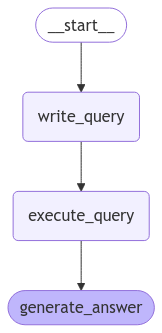

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let’s _stream_ a new question through the flow. This mode of operation displays the output of each step as it is executed, essential for understanding the flow’s behavior, particularly when it is not behaving as expected! The model returns structured text in [Markdown](https://en.wikipedia.org/wiki/Markdown) format; with a little code to extract the message from the `step` variable, we can use the `display_markdown` function to render each step’s output:

In [15]:
from IPython.display import display_markdown
from more_itertools import one

# Add a horizontal rule before each step output, apart from the first
hr = ''
for step in graph.stream(
    {"question": "Each drive has its own serial number. How many drives did each data center have on 9/1/2024?"}, stream_mode="updates"
):
    # For this graph, step has the form {'node_name': {'key', 'message'}},
    # where node_name is one of 'write_query', 'execute_query', or
    # 'generate_answer' and key is one of 'query', 'result' or 'answer'.
    #
    # one gives us the first element of an iterable, allowing us to
    # conveniently get the wrapped value.
    state = one(step.values())
    message = hr + one(state.values())
    if len(hr) == 0:
        hr = '---\n'
    display_markdown(message, raw=True)

SELECT datacenter, COUNT(DISTINCT serial_number) AS drive_count 
FROM drivestats 
WHERE date = DATE '2024-09-01' 
GROUP BY datacenter 
ORDER BY drive_count DESC 
LIMIT 10

---
[('phx1', 89477), ('sac0', 78444), ('sac2', 60775), ('', 24080), ('iad1', 22800), ('ams5', 16139)]

---
On September 1, 2024, the data centers had the following number of drives:

- **phx1**: 89,477 drives
- **sac0**: 78,444 drives
- **sac2**: 60,775 drives
- **(empty datacenter)**: 24,080 drives
- **iad1**: 22,800 drives
- **ams5**: 16,139 drives

These are the top data centers with the highest drive counts on that date.

As you can see in the output from the first step, the model generated an invalid query, despite the database schema being included in the prompt. The output of the second step contains the resulting error message from the database, while the third step contains the model’s diagnosis of the error.

This exchange highlights a limitation of a flow that is simply a linear series of steps, such as `write_query`, `execute_query` and `generate_answer`: we cannot rely on the model to generate a valid SQL query, although it is able to point the way towards resolving its error.

## Creating a ReAct AI Agent with LangGraph

The LangGraph framework gives you the capability to create AI agents based on arbitrarily complex logic. In this article, I’ve used its prebuilt [ReAct](https://react-lm.github.io/) (Reason+Act) agent, since it neatly demonstrates the agent concept, rewriting the SQL query repeatedly in response to database errors.

There are three steps to creating the agent. The first is to create an instance of LangChain's [SQLDatabaseToolkit](https://python.langchain.com/api_reference/community/agent_toolkits/langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit.html), passing it the database and model, and obtain its list of tools:

In [16]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x106a5bda0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x106a5bda0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x106a5bda0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

The `tools` list contains tools that execute queries, retrieve the names, schemas and content of database tables, and check SQL query syntax.

The next step is to retrieve a suitable prompt template from the Prompt Hub and populate the template placeholders:

In [17]:
from langchain import hub

# Suppress the LandSmith API key warning - we don't need it to do hub.pull
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [18]:
system_message = prompt_template.format(dialect=db.dialect, top_k=10)

Now we can create an instance of the prebuilt agent:

In [19]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, state_modifier=system_message)

Note how the agent must select the next step, and how the flow can cycle between the agent and tools steps:

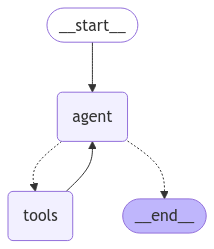

In [20]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

Again, we can stream the agent’s execution to show us each step of its operation.

In [21]:
for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": "Each drive has its own serial number. How many drives did each data center have on 9/1/2024?"}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Each drive has its own serial number. How many drives did each data center have on 9/1/2024?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_7RUubYpslcxlUTUKDfo3F018)
 Call ID: call_7RUubYpslcxlUTUKDfo3F018
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

drivestats
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_BjZsgcZGJCu0OSjTAxIDLkmz)
 Call ID: call_BjZsgcZGJCu0OSjTAxIDLkmz
  Args:
    table_names: drivestats
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE drivestats (
	date DATE, 
	serial_number VARCHAR, 
	model VARCHAR, 
	capacity_bytes BIGINT, 
	failure INTEGER, 
	smart_1_raw BIGINT, 
	smart_5_raw BIGINT, 
	smart_9_raw BIGINT, 
	s

Execution cycles between the `agent` and `tools` steps several times, generating and executing queries, before it generates its final, correct answer.

Now let’s see if the model can calculate the annualized failure rate of a drive model. We’ll use the Seagate ST4000DM000, just because that is the drive model with the most days of operation in the dataset.

In [22]:
for step in agent_executor.stream(
        {"messages": [{"role": "user", "content": "Each drive has its own serial number. What is the annualized failure rate of the ST4000DM000 drive model?"}]},
        stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Each drive has its own serial number. What is the annualized failure rate of the ST4000DM000 drive model?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_C2NZjn5ztl7Sa12BOXUtbPEy)
 Call ID: call_C2NZjn5ztl7Sa12BOXUtbPEy
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

drivestats
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_jl4yMfvV3aF4wWtyp0vWjGkf)
 Call ID: call_jl4yMfvV3aF4wWtyp0vWjGkf
  Args:
    table_names: drivestats
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE drivestats (
	date DATE, 
	serial_number VARCHAR, 
	model VARCHAR, 
	capacity_bytes BIGINT, 
	failure INTEGER, 
	smart_1_raw BIGINT, 
	smart_5_raw BIGINT, 
	smart_9_ra

It’s impressive that the agent shows its working so comprehensively, but, unfortunately, it arrives at the wrong answer. Those drives were not all running for the entire span of the Drive Stats data set. The correct calculation involves determining the number of days with data for those drives and dividing it by 365 to get the correct number of years’ operation.

It’s clear that the model is not able to answer questions on drive reliability given the data available to it so far. The solution lies in [prompt engineering](https://en.wikipedia.org/wiki/Prompt_engineering) - providing more context on the semantics of the data in the system prompt.

We can extend the default AI agent system prompt template to include specific instructions on working with the Drive Stats data set:

In [23]:
prompt_template.messages[0].prompt.template += """
Each row of the drivestats table records one day of a drive’s operation, and contains the serial number of a drive, its model name, capacity in bytes, whether it failed on that day, SMART attributes and identifiers for the slot, pod, vault, cluster and data center in which it is located.

Use this calculation for the annualized failure rate (AFR) for a drive model over a given time period:

1. **drive_days** is the number of rows for that model during the time period.
2. **failures** is the number of rows for that model during the time period where **failure** is equal to 1.
3. **annual failure rate** is 100 * (**failures** / (**drive_days** / 365)).

Use double precision arithmetic in the calculation to avoid truncation errors. To convert an integer **i** to a double, use CAST(**i** AS DOUBLE)

Note that the date column is a DATE type, not a string. Use the DATE type identifier when comparing the date column to a string.

Do not add a semi-colon suffix to SQL queries."""

We need to recreate the `system_message` and `agent_executor` with the new prompt template:

In [24]:
system_message = prompt_template.format(dialect=db.dialect, top_k=10)
agent_executor = create_react_agent(llm, tools, state_modifier=system_message)

Now, when we ask the same question on the annual failure rate of the ST4000DM000 drive model, the AI agent generates the correct SQL query and a more concise, and correct, final response.

In [25]:
for step in agent_executor.stream(
        {"messages": [{"role": "user", "content": "What is the annual failure rate of the ST4000DM000 drive model?"}]},
        stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the annual failure rate of the ST4000DM000 drive model?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_oIsYlBEXcb6JiFj9Eo81RI2L)
 Call ID: call_oIsYlBEXcb6JiFj9Eo81RI2L
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

drivestats
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_hdXAlLwZhrUlCLgIsp3tALYn)
 Call ID: call_hdXAlLwZhrUlCLgIsp3tALYn
  Args:
    table_names: drivestats
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE drivestats (
	date DATE, 
	serial_number VARCHAR, 
	model VARCHAR, 
	capacity_bytes BIGINT, 
	failure INTEGER, 
	smart_1_raw BIGINT, 
	smart_5_raw BIGINT, 
	smart_9_raw BIGINT, 
	smart_194_raw BIGINT, 
	smart_

Let’s ask the AI agent for a statistic that we can corroborate from the [Backblaze Drive Stats for Q3 2024](https://www.backblaze.com/blog/backblaze-drive-stats-for-q3-2024/) blog post.

In [26]:
for step in agent_executor.stream(
        {"messages": [{"role": "user", "content": "What was the annual failure rate of the ST8000NM000A drive model in Q3 2024?"}]},
        stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What was the annual failure rate of the ST8000NM000A drive model in Q3 2024?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_F3Wil2gD3VBSOPN9obwK4NGt)
 Call ID: call_F3Wil2gD3VBSOPN9obwK4NGt
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

drivestats
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_SJtUScbSCUQjQgjz4C7UMBCz)
 Call ID: call_SJtUScbSCUQjQgjz4C7UMBCz
  Args:
    table_names: drivestats
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE drivestats (
	date DATE, 
	serial_number VARCHAR, 
	model VARCHAR, 
	capacity_bytes BIGINT, 
	failure INTEGER, 
	smart_1_raw BIGINT, 
	smart_5_raw BIGINT, 
	smart_9_raw BIGINT, 
	smart_194_raw BIG

The query makes sense, and the response agrees with the table in the blog post.

Finally, let’s ask a more convoluted question, including the constraints given in the blog post:

In [27]:
response = agent_executor.invoke(
    {"messages": [{"role": "user", "content": "Considering only drive models which had at least 100 drives in service at the end of the quarter and which accumulated 10,000 or more drive days during the quarter, which drive had the most failures in Q3 2024, and what was its failure rate?"}]}
)

# Show the SQL query sent to the database
print(response['messages'][-3].tool_calls[0]['args']['query'])

# Show the final response message
display_markdown(response['messages'][-1].content, raw=True)

WITH drive_summary AS (
    SELECT model, COUNT(DISTINCT serial_number) AS drive_count,
           SUM(CASE WHEN failure = 1 THEN 1 ELSE 0 END) AS failure_count,
           COUNT(*) AS drive_days
    FROM drivestats
    WHERE date BETWEEN DATE '2024-07-01' AND DATE '2024-09-30'
    GROUP BY model
    HAVING COUNT(DISTINCT serial_number) >= 100 AND COUNT(*) >= 10000
)
SELECT model, failure_count,
       100 * (CAST(failure_count AS DOUBLE) / (CAST(drive_days AS DOUBLE) / 365)) AS failure_rate
FROM drive_summary
ORDER BY failure_count DESC
LIMIT 1


The drive model with the most failures in Q3 2024 was **TOSHIBA MG08ACA16TA**, which had **181 failures** and an annualized failure rate of approximately **1.84%**.

Again, the AI agent is able to generate a valid SQL query, this time including a subquery, and its response matches the data from the blog post exactly.